In [ ]:
# Required Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# === CONFIGURATION ===
red_teams = ['86254B', '2775V']
blue_teams = ['1065A', '3131V']
kpi_file = "innov_kpi_summary.csv"
ccwm_file = "ccwm.csv"

In [ ]:
# === KPIs to Plot (with exact header names) ===
selected_kpis = [
    'All Win Rate',
    'All Avg For',
    'Weighted Avg For',
    'Weighted Normalized Win Margin',
    'Regional+ Win Rate',
    'ccwm',
    'opr'
]

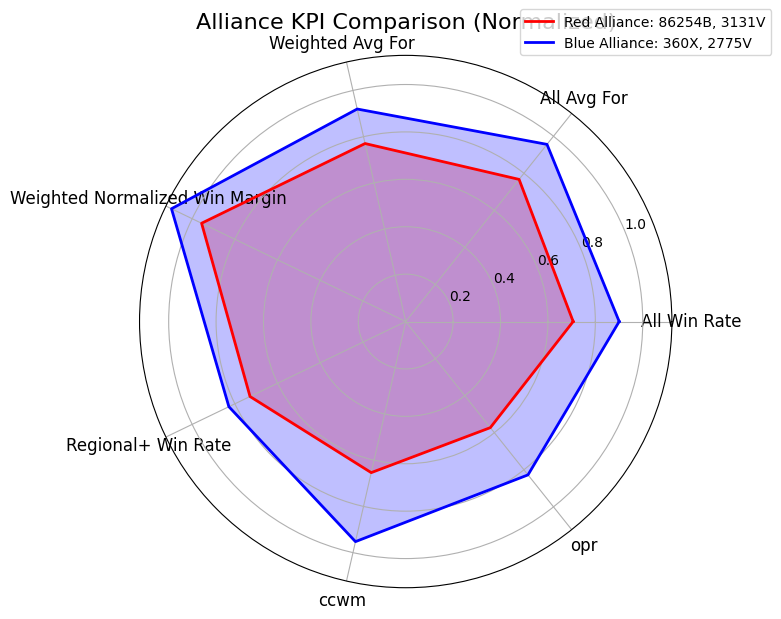

In [32]:
# === Load KPI and CCWM Data ===
kpi_df = pd.read_csv(kpi_file)
ccwm_df = pd.read_csv(ccwm_file)

# Normalize and align team numbers
kpi_df['Team'] = kpi_df['Team'].astype(str).str.strip().str.upper()
ccwm_df['team_number'] = ccwm_df['team_number'].astype(str).str.strip().str.upper()
ccwm_df.rename(columns={'team_number': 'Team'}, inplace=True)

# Merge KPI and CCWM/OPR
full_df = pd.merge(kpi_df, ccwm_df[['Team', 'ccwm', 'opr']], on='Team', how='left')

# Filter for selected teams
red_teams = [t.strip().upper() for t in red_teams]
blue_teams = [t.strip().upper() for t in blue_teams]
team_subset = red_teams + blue_teams
filtered_df = full_df[full_df['Team'].isin(team_subset)].copy()

if filtered_df.empty:
    raise ValueError("None of the specified teams found in KPI or CCWM data.")

# === Normalization Factors ===
norm_factors = {}

# Top-2 sum normalization
for kpi in ['All Win Rate', 'All Avg For', 'Weighted Avg For', 'Regional+ Win Rate', 'opr']:
    top_two = full_df[kpi].dropna().unique()
    top_two.sort()
    if len(top_two) >= 2:
        norm_factors[kpi] = top_two[-1] + top_two[-2]
    elif len(top_two) == 1:
        norm_factors[kpi] = top_two[0] * 2
    else:
        norm_factors[kpi] = 1  # fallback

# Min-max sum normalization for WNWM and CCWM
for kpi in ['Weighted Normalized Win Margin', 'ccwm']:
    values = full_df[kpi].dropna().values
    pair_sums = [x + y for i, x in enumerate(values) for j, y in enumerate(values) if i != j]
    if pair_sums:
        norm_factors[kpi] = (min(pair_sums), max(pair_sums))
    else:
        norm_factors[kpi] = (0, 1)  # fallback

# === Normalize Selected KPIs ===
normalized_df = filtered_df.copy()
for kpi in selected_kpis:
    if kpi in ['Weighted Normalized Win Margin', 'ccwm']:
        min_val, max_val = norm_factors[kpi]
        normalized_df[kpi] = (filtered_df[kpi] + abs(min_val)) / (max_val + abs(min_val) + 1e-8)
    else:
        normalized_df[kpi] = filtered_df[kpi] / (norm_factors[kpi] + 1e-8)

# === Compute Alliance Scores ===
def compute_alliance_values(df, teams):
    alliance_df = df[df['Team'].isin(teams)]
    return [alliance_df[kpi].nlargest(2).sum() for kpi in selected_kpis]

red_values = compute_alliance_values(normalized_df, red_teams)
blue_values = compute_alliance_values(normalized_df, blue_teams)

# Close radar chart shape
red_values.append(red_values[0])
blue_values.append(blue_values[0])

# === Radar Chart Plot ===
labels = selected_kpis
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles.append(angles[0])

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

ax.plot(angles, red_values, color='red', linewidth=2, label=f'Red Alliance: {red_teams[0]}, {red_teams[1]}')
ax.fill(angles, red_values, color='red', alpha=0.25)

ax.plot(angles, blue_values, color='blue', linewidth=2, label=f'Blue Alliance: {blue_teams[0]}, {blue_teams[1]}')
ax.fill(angles, blue_values, color='blue', alpha=0.25)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=12)
ax.set_title("Alliance KPI Comparison (Normalized)", size=16, pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))

plt.tight_layout()
plt.show()

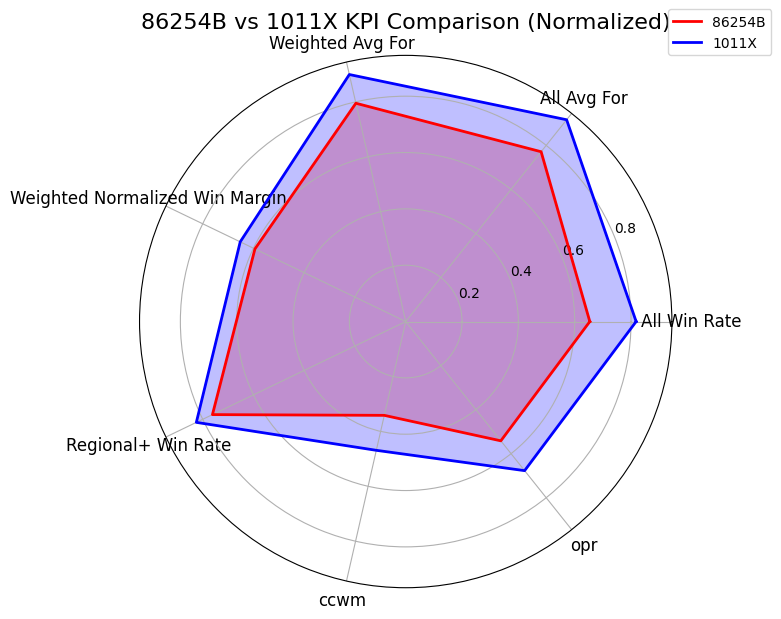

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === File Paths ===
kpi_file = "innov_kpi_summary.csv"
ccwm_file = "ccwm.csv"

# === Teams to Compare ===
team_1 = '86254B'
team_2 = '1011X'

# === KPIs to Include ===
selected_kpis = [
    'All Win Rate',
    'All Avg For',
    'Weighted Avg For',
    'Weighted Normalized Win Margin',
    'Regional+ Win Rate',
    'ccwm',
    'opr'
]

# === Load KPI and CCWM Data ===
kpi_df = pd.read_csv(kpi_file)
ccwm_df = pd.read_csv(ccwm_file)

# Normalize and align team numbers
kpi_df['Team'] = kpi_df['Team'].astype(str).str.strip().str.upper()
ccwm_df['team_number'] = ccwm_df['team_number'].astype(str).str.strip().str.upper()
ccwm_df.rename(columns={'team_number': 'Team'}, inplace=True)

# Merge KPI and CCWM/OPR
full_df = pd.merge(kpi_df, ccwm_df[['Team', 'ccwm', 'opr']], on='Team', how='left')

# Filter for selected teams
team_1 = team_1.strip().upper()
team_2 = team_2.strip().upper()
team_subset = [team_1, team_2]
filtered_df = full_df[full_df['Team'].isin(team_subset)].copy()

if filtered_df.empty:
    raise ValueError("None of the specified teams found in KPI or CCWM data.")

# === Normalization Factors ===
norm_factors = {}

# Top-2 sum normalization
for kpi in ['All Win Rate', 'All Avg For', 'Weighted Avg For', 'Regional+ Win Rate', 'opr']:
    top_two = full_df[kpi].dropna().unique()
    top_two.sort()
    norm_factors[kpi] = max(top_two)

# Min-max sum normalization for WNWM and CCWM
for kpi in ['Weighted Normalized Win Margin', 'ccwm']:
    values = full_df[kpi].dropna().values
    norm_factors[kpi] = (min(values), max(values))

# === Normalize Selected KPIs ===
normalized_df = filtered_df.copy()
for kpi in selected_kpis:
    if kpi in ['Weighted Normalized Win Margin', 'ccwm']:
        min_val, max_val = norm_factors[kpi]
        normalized_df[kpi] = (filtered_df[kpi] + abs(min_val)) / (max_val + abs(min_val) + 1e-8)
    else:
        normalized_df[kpi] = filtered_df[kpi] / (norm_factors[kpi] + 1e-8)

# === Get Individual Team Values ===
team1_values = normalized_df[normalized_df['Team'] == team_1][selected_kpis].values.flatten().tolist()
team2_values = normalized_df[normalized_df['Team'] == team_2][selected_kpis].values.flatten().tolist()

# Close radar chart shape
team1_values.append(team1_values[0])
team2_values.append(team2_values[0])

# === Radar Chart Plot ===
labels = selected_kpis
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles.append(angles[0])

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

ax.plot(angles, team1_values, color='red', linewidth=2, label=team_1)
ax.fill(angles, team1_values, color='red', alpha=0.25)

ax.plot(angles, team2_values, color='blue', linewidth=2, label=team_2)
ax.fill(angles, team2_values, color='blue', alpha=0.25)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=12)
ax.set_title(f"{team_1} vs {team_2} KPI Comparison (Normalized)", size=16, pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))

plt.tight_layout()
plt.show()
